In [1]:
import glob
import sys
from pathlib import Path
sys.path.append(
    str(Path().absolute())
)

from Backbone.DTI_autoencoder import *
# from Utils.train_utils import *
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import shap
import umap

c:\Users\vishw\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
available_ids = [
    1, 2, 4, 5, 7, 8, 9, 11, 13, 14, 17, 22, 23, 24, 25, 27, 28, 29, 30, 31, 
    32, 34, 35, 39, 44, 46, 47, 48, 49, 50, 51, 53, 57, 58, 59, 60, 61, 62, 63, 
    64, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 79, 80, 81, 83, 84, 86, 87, 88, 
    89, 95, 96, 97, 99, 101, 103, 105, 109, 112, 120
]

In [3]:
master_sheet = pd.read_csv('../Dataset/NEUROFIT_diffusion_features.csv')
## Filter master_sheet for available_ids
master_sheet = master_sheet[master_sheet['Subject'].str.split('_').str[1].astype(int).isin(available_ids)]
fa_cols = [col for col in master_sheet.columns if ('_fa1_mean' in col)]
dti_representation = np.load('../Dataset/NEUROFIT_diffusion/aggregated_grid.npy', allow_pickle=True)
# master_sheet['Subject_ID_number'] = master_sheet['Subject_ID'].apply(lambda a: int(a.split('_')[1]))

In [4]:
fa_values = master_sheet[fa_cols]
## Remove _fa1_mean from the column names
fa_values.columns = fa_values.columns.str.replace('_fa1_mean', '')
additional_covariates = master_sheet.iloc[:, -4:-1]
target = (master_sheet['sex']=='Males').astype(int)

In [5]:
train_subjects = ['NEUROFIT_036', 'NEUROFIT_053', 'NEUROFIT_077', 'NEUROFIT_010',
       'NEUROFIT_041', 'NEUROFIT_120', 'NEUROFIT_017', 'NEUROFIT_090',
       'NEUROFIT_099', 'NEUROFIT_095', 'NEUROFIT_032', 'NEUROFIT_103',
       'NEUROFIT_097', 'NEUROFIT_108', 'NEUROFIT_045', 'NEUROFIT_063',
       'NEUROFIT_027', 'NEUROFIT_101', 'NEUROFIT_088', 'NEUROFIT_048',
       'NEUROFIT_009', 'NEUROFIT_077', 'NEUROFIT_102', 'NEUROFIT_090',
       'NEUROFIT_004', 'NEUROFIT_010', 'NEUROFIT_066', 'NEUROFIT_025',
       'NEUROFIT_098', 'NEUROFIT_038', 'NEUROFIT_046', 'NEUROFIT_055',
       'NEUROFIT_044', 'NEUROFIT_096', 'NEUROFIT_015', 'NEUROFIT_112',
       'NEUROFIT_031', 'NEUROFIT_059', 'NEUROFIT_108', 'NEUROFIT_032',
       'NEUROFIT_061', 'NEUROFIT_013', 'NEUROFIT_091', 'NEUROFIT_046',
       'NEUROFIT_058', 'NEUROFIT_082', 'NEUROFIT_096', 'NEUROFIT_077',
       'NEUROFIT_084', 'NEUROFIT_105', 'NEUROFIT_064', 'NEUROFIT_065',
       'NEUROFIT_098', 'NEUROFIT_065', 'NEUROFIT_076', 'NEUROFIT_066',
       'NEUROFIT_077', 'NEUROFIT_063', 'NEUROFIT_106', 'NEUROFIT_015',
       'NEUROFIT_035', 'NEUROFIT_043', 'NEUROFIT_042', 'NEUROFIT_051',
       'NEUROFIT_077', 'NEUROFIT_041', 'NEUROFIT_096', 'NEUROFIT_025',
       'NEUROFIT_033', 'NEUROFIT_088', 'NEUROFIT_052', 'NEUROFIT_076',
       'NEUROFIT_026', 'NEUROFIT_076', 'NEUROFIT_104', 'NEUROFIT_052',
       'NEUROFIT_068', 'NEUROFIT_028', 'NEUROFIT_007', 'NEUROFIT_058']

## Get train and test indices
train_idx = master_sheet['Subject'].apply(lambda a: a in train_subjects)
test_idx = ~train_idx

In [6]:
def convert_to_representation(dataframe, representation):
    '''
    Convert the representation to a matrix
    
    Parameters:
    dataframe: pd.DataFrame
        The dataframe containing the values of the representation
    representation: np.array
        The representation of the data

    Returns:
    array: np.array
        The matrix representation of the given dataframe
    '''
    array = np.zeros((representation.shape[0], representation.shape[1]))
    for (i, j), val in np.ndenumerate(representation):
        if val == '':
            array[i, j] = 0
        else:
            array[i, j] = dataframe.loc[val]

    return array

In [7]:
fa_representation = fa_values.apply(lambda x: convert_to_representation(x, dti_representation), axis=1)
fa_representation = np.stack(fa_representation.values)

In [8]:
## Merging X and Y and train-test split
X = fa_representation
# # Generate 105 random values (one for each 9x9 matrix)
# random_values = np.random.rand(X.shape[0])

# # Add each random value to the bottom-right element (index [8, 8]) of each 9x9 matrix
# fa_representation[:, 8, 8] += random_values

## Expand X dimension at -1
X = np.expand_dims(X, axis=-1)
## Permute to n,c,h,w
X = np.transpose(X, (0, 3, 1, 2))
Y = np.array(target)

## Train-test split
X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

## Convert into dataloaders for pytorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
# dti_representation[8,8] = 'Random'

## Training Pipeline

In [10]:
def train_model(train_loader, test_loader, model, optimizer, n_epochs=100, batch_size=32, verbose=True):
    '''
    Function to train a regression model

    Parameters
    ----------
    X_train : np.array
        Training data
    y_train : np.array
        Training labels
    X_test : np.array
        Testing data
    y_test : np.array
        Testing labels
    model : torch.nn.Module
        Pytorch model
    optimizer : torch.optim
        Pytorch optimizer
    n_epochs : int
        Number of epochs
    batch_size : int
        Batch size

    Returns
    -------
    model : torch.nn.Module
        Trained model
    '''
    device = torch.device('cuda')
    model.to(device)
    best_loss = np.inf 
    es_counter = 0
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_vae_loss = 0
        train_loss_recon = 0
        train_loss_kl = 0
        train_loss_class = 0
        train_loss_l1 = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            x_recon, class_logits, mu, logvar, fm_feats = model(X_batch)
            ## Get the latent vector
            z = model.reparameterize(mu, logvar)
            ## Flatten class logits
            class_logits = class_logits.view(-1)
            ## Get the wegiths from fc_mu and fc_logvar
            l1_matrix = None
            total_loss, total_vae_loss, recon_loss, kl_loss, class_loss, l1_loss = autoencoder_loss(X_batch, x_recon, y_batch, class_logits, z, mu, logvar, l1_matrix = l1_matrix, class_loss_weight=1.25, vae_loss_weight=0.25, beta=5)

            target_loss = total_loss
            target_loss.backward()
            optimizer.step()

            ## Getting the loss for training
            train_loss += total_loss.item()
            train_vae_loss += total_vae_loss.item()
            train_loss_recon += recon_loss.item()
            train_loss_kl += kl_loss.item()
            train_loss_class += class_loss.item()
            train_loss_l1 += l1_loss.item()

        model.eval()
        test_loss = 0
        test_vae_loss = 0
        test_loss_recon = 0
        test_loss_kl = 0
        test_loss_class = 0
        test_loss_l1 = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                x_recon, class_logits, mu, logvar, fm_feats  = model(X_batch)
                ## Get the latent vector
                z = model.reparameterize(mu, logvar)
                class_logits = class_logits.view(-1)
                ## Get the wegiths from fc_mu and fc_logvar
                l1_matrix = None
                total_loss, total_vae_loss, recon_loss, kl_loss, class_loss, l1_loss = autoencoder_loss(X_batch, x_recon, y_batch, class_logits, z, mu, logvar, l1_matrix = l1_matrix, class_loss_weight=1.25, vae_loss_weight=0.25, beta=5)
                ## Getting the loss for testing
                test_loss += total_loss.item()
                test_vae_loss += total_vae_loss.item()
                test_loss_recon += recon_loss.item()
                test_loss_kl += kl_loss.item()
                test_loss_class += class_loss.item()
                test_loss_l1 += l1_loss.item()

        train_losses.append({'total_loss': train_loss/len(train_loader), 'vae_loss': train_vae_loss/len(train_loader), 'recon_loss': train_loss_recon/len(train_loader), 'kl_loss': train_loss_kl/len(train_loader), 'class_loss': train_loss_class/len(train_loader), 'l1_loss': train_loss_l1/len(train_loader)})
        test_losses.append({'total_loss': test_loss/len(test_loader), 'vae_loss': test_vae_loss/len(train_loader), 'recon_loss': test_loss_recon/len(test_loader), 'kl_loss': test_loss_kl/len(test_loader), 'class_loss': test_loss_class/len(test_loader), 'l1_loss': test_loss_l1/len(test_loader)})
        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print("Training")
            print(f'Total Loss: {train_loss/len(train_loader)}')
            print(f'Total VAE Loss: {train_vae_loss/len(train_loader)}')
            print(f'Recon Loss: {train_loss_recon/len(train_loader)}, KL Loss: {train_loss_kl/len(train_loader)}, Class Loss: {train_loss_class/len(train_loader)}')

            print("Testing")
            print(f'Total Loss: {test_loss/len(test_loader)}')
            print(f'Total VAE Loss: {test_vae_loss/len(test_loader)}')
            print(f'Recon Loss: {test_loss_recon/len(test_loader)}, KL Loss: {test_loss_kl/len(test_loader)}, Class Loss: {test_loss_class/len(test_loader)}')
            print('------------------------------------\n')

        ## Track the best model
        if test_loss < best_loss:
            best_loss = test_loss
            ## Save the model temporarily
            if verbose:
                print("**** Saving the model ***\n")
            torch.save(model.state_dict(), '../Dataset/Saved_models/temp_best_model.pth')
            es_counter = 0
            
        else:
            es_counter += 1
            
        if es_counter == 20 or epoch == n_epochs-1:
            print('Early stopping')
            print(f'Best Test loss: {best_loss}')
            ## Load the best model
            model.load_state_dict(torch.load('../Dataset/Saved_models/temp_best_model.pth'))
            return model, best_loss, {'train': train_losses, 'test': test_losses}
        

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [12]:
## Repeated KFold test
from sklearn.model_selection import RepeatedKFold
from lazypredict.supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier

rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
accuracy = []
f1 = []
accuracy_knn = []
device = torch.device('cuda')
for train_index, test_index in tqdm(rkf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    backbone = Spatial_DTI_autoencoder(num_classes=1, latent_dim=4, fm_latent_dim=16)
    optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()
    model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=1000,
                    batch_size=16,
                    verbose=False)
    ## Extract the latent vectors for X_test 
    _, _, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get reparepresentation of the test data
    mu_test = mu.cpu().detach().numpy()
    fm_feats_test = fm_feats.cpu().detach().numpy()

    ## Get the latent vectors for X_train
    _, _, mu, logvar, fm_feats = model(torch.tensor(X_train, dtype=torch.float32).to(device))
    ## Get reparepresentation of the train data
    mu_train = mu.cpu().detach().numpy()
    fm_feats_train = fm_feats.cpu().detach().numpy()

    ## Concatenate the fm_feats and mu
    fm_feats_train = np.concatenate([fm_feats_train, mu_train], axis=1)
    fm_feats_test = np.concatenate([fm_feats_test, mu_test], axis=1)

    clf = LazyClassifier()
    clf = clf.fit(fm_feats_train,fm_feats_test, Y_train, y_test=Y_test)
    clf[0].head(10)  # Display top 10 models
    best_acc = clf[0].values[0,0]
    best_f1 = clf[0].values[0,-2]
    accuracy.append(best_acc)
    f1.append(best_f1)

    ## Get the KNN accuracy of the latent representation
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(mu_test, Y_test)
    y_pred = knn.predict(mu_test)
    accuracy_score(Y_test, y_pred)
    accuracy_knn.append(accuracy_score(Y_test, y_pred))


print("Mean Accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))
print("Std Accuracy: ", np.std(accuracy))
print("Std F1: ", np.std(f1))

0it [00:00, ?it/s]

Early stopping
Best Test loss: 1.1241075992584229


100%|██████████| 29/29 [00:01<00:00, 19.96it/s]


[LightGBM] [Info] Number of positive: 39, number of negative: 23
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629032 -> initscore=0.528067
[LightGBM] [Info] Start training from score 0.528067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 28.50it/s]


[LightGBM] [Info] Number of positive: 38, number of negative: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612903 -> initscore=0.459532
[LightGBM] [Info] Start training from score 0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

100%|██████████| 29/29 [00:01<00:00, 25.15it/s]


[LightGBM] [Info] Number of positive: 37, number of negative: 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596774 -> initscore=0.392042
[LightGBM] [Info] Start training from score 0.392042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 28.96it/s]


[LightGBM] [Info] Number of positive: 38, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612903 -> initscore=0.459532
[LightGBM] [Info] Start training from score 0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 28.22it/s]


[LightGBM] [Info] Number of positive: 38, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612903 -> initscore=0.459532
[LightGBM] [Info] Start training from score 0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 27.38it/s]


[LightGBM] [Info] Number of positive: 38, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612903 -> initscore=0.459532
[LightGBM] [Info] Start training from score 0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 28.22it/s]


[LightGBM] [Info] Number of positive: 37, number of negative: 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596774 -> initscore=0.392042
[LightGBM] [Info] Start training from score 0.392042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:00<00:00, 29.36it/s]


[LightGBM] [Info] Number of positive: 38, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612903 -> initscore=0.459532
[LightGBM] [Info] Start training from score 0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:00<00:00, 29.42it/s]


[LightGBM] [Info] Number of positive: 36, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580645 -> initscore=0.325422
[LightGBM] [Info] Start training from score 0.325422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 29/29 [00:01<00:00, 27.03it/s]

[LightGBM] [Info] Number of positive: 39, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619048 -> initscore=0.485508
[LightGBM] [Info] Start training from score 0.485508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [102]:
backbone = Spatial_DTI_autoencoder(num_classes=1, latent_dim=4, fm_latent_dim=16)
optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)

## Move to device
device = torch.device('cuda')
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=10000,
                    batch_size=16,
                    verbose=True)

x_recon, y_pred, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32))

Epoch 1/10000
Training
Total Loss: 141.54267692565918
Total VAE Loss: 550.8373947143555
Recon Loss: 548.7411804199219, KL Loss: 2.0962257385253906, Class Loss: 3.0666626691818237
Testing
Total Loss: 77.58717346191406
Total VAE Loss: 306.57102966308594
Recon Loss: 304.5557098388672, KL Loss: 2.0153242349624634, Class Loss: 0.7555313110351562
------------------------------------

**** Saving the model ***

Epoch 2/10000
Training
Total Loss: 82.2327766418457
Total VAE Loss: 314.51255798339844
Recon Loss: 312.16139221191406, KL Loss: 2.3511708974838257, Class Loss: 2.8837085962295532
Testing
Total Loss: 25.082672119140625
Total VAE Loss: 96.96648025512695
Recon Loss: 94.74154663085938, KL Loss: 2.2249326705932617, Class Loss: 0.6728420853614807
------------------------------------

**** Saving the model ***

Epoch 3/10000
Training
Total Loss: 32.37888145446777
Total VAE Loss: 119.94227600097656
Recon Loss: 117.02251434326172, KL Loss: 2.9197630882263184, Class Loss: 1.914649486541748
Testi

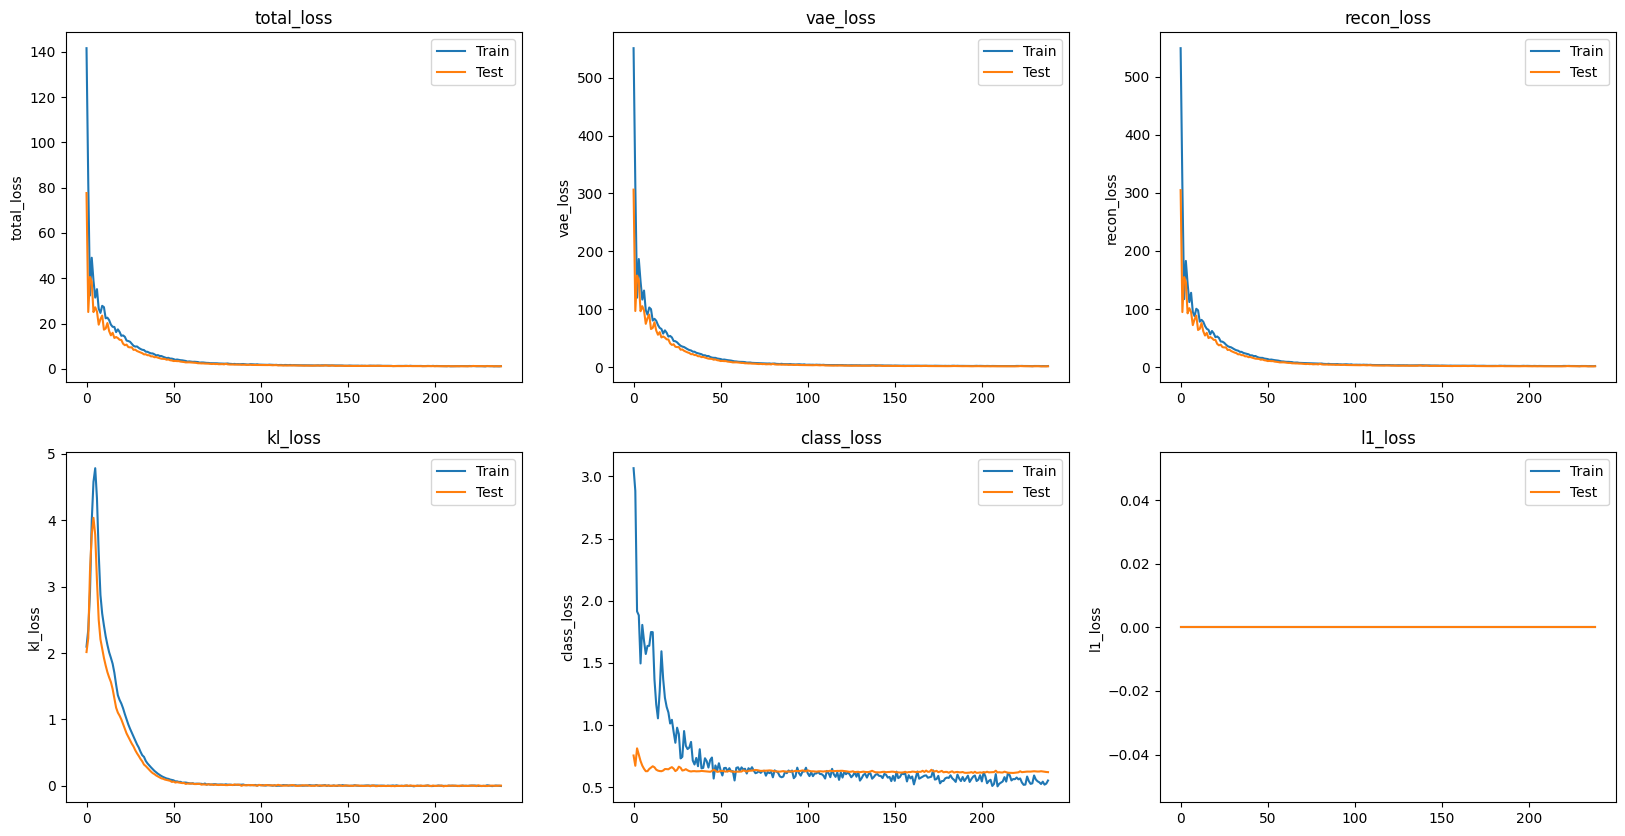

In [103]:
## Plot the trainig losses
train_losses = loss_dict['train']
test_losses = loss_dict['test']
train_losses = pd.DataFrame(train_losses)
test_losses = pd.DataFrame(test_losses)

## Plot all losses in subplots
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i,c in enumerate(train_losses.columns):
    sns.lineplot(data=train_losses[c], ax=ax[i//3, i%3], label='Train')
    sns.lineplot(data=test_losses[c], ax=ax[i//3, i%3], label='Test')
    ax[i//3, i%3].set_title(c)



In [104]:
## Save the model
torch.save(model.state_dict(), '../Dataset/Saved_models/DTI_autoencoder.pth')

## Visualization

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Spatial_DTI_autoencoder(num_classes=1, latent_dim=4, fm_latent_dim=16)
model.load_state_dict(torch.load('../Dataset/Saved_models/DTI_autoencoder.pth')) 
model = model.to(device)

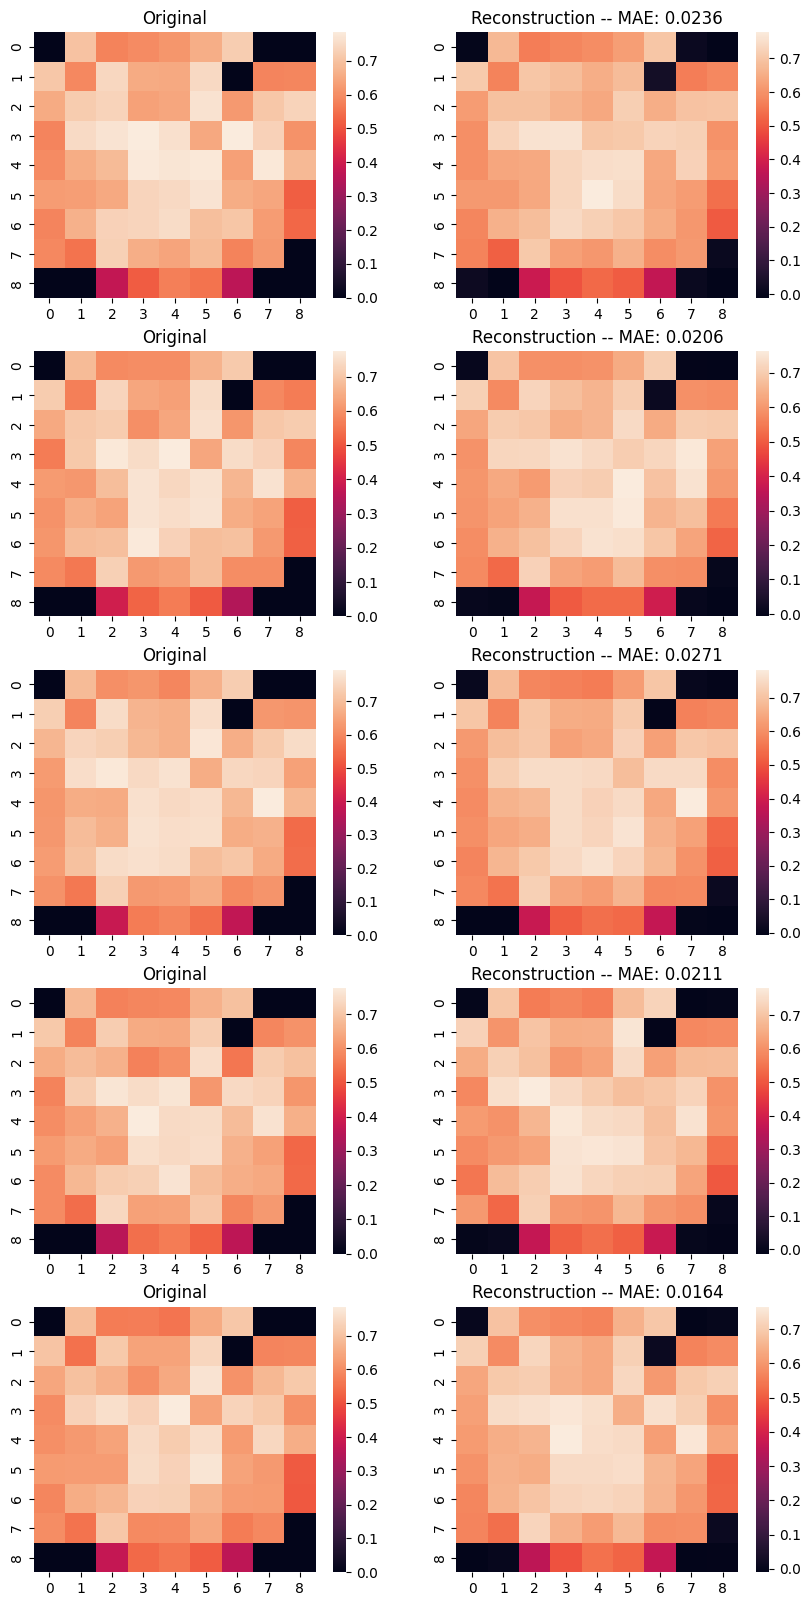

In [106]:
## Get the prediction on Y_test
x_recon, y_pred, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32).to(device))

## Make a color plot of x_recon and X_test for 5 samples
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    sns.heatmap(X_test[i][0].cpu().detach().numpy(), ax=ax[i, 0])
    sns.heatmap(x_recon[i].cpu().detach().numpy().squeeze(), ax=ax[i, 1])

    ## Calculate mean absolute error
    mae = np.abs(X_test[i][0].cpu().detach().numpy() - x_recon[i].cpu().detach().numpy().squeeze()).mean()
    ## Add this to the title as a super title
    ax[i, 0].set_title("Original")
    ax[i, 1].set_title(f'Reconstruction -- MAE: %1.4f' % mae)
    
plt.show()

In [107]:
## Plot conf matrix of y_pred and Y_test
y_pred_classes = y_pred.cpu().detach().numpy()
Y_test_classes = Y_test.cpu().detach().numpy()
y_pred_classes = np.where(y_pred_classes > 0.5, 1, 0)
Y_test_classes = np.where(Y_test_classes > 0.5, 1, 0)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(Y_test_classes, y_pred_classes)
display(pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']).style.background_gradient(axis=None))
## Print classification report
report = classification_report(Y_test_classes, y_pred_classes, target_names=['0', '1'], output_dict=True)
## Print the report as a dataframe
report = pd.DataFrame(report).transpose()
display(report.style.background_gradient(cmap='Blues'))


,Predicted 0,Predicted 1
Actual 0,17,4
Actual 1,17,10


,precision,recall,f1-score,support
0,0.500000,0.809524,0.618182,21.000000
1,0.714286,0.370370,0.487805,27.000000
accuracy,0.562500,0.562500,0.562500,0.562500
macro avg,0.607143,0.589947,0.552993,48.000000
weighted avg,0.620536,0.562500,0.544845,48.000000


In [108]:
## Calculate reconstruction loss on test
recon_loss = np.abs(X_test.cpu().detach().numpy() - x_recon.cpu().detach().numpy()).mean(axis=(1, 2, 3))
recon_loss = pd.DataFrame(recon_loss, columns=['Reconstruction Loss'])
recon_loss['Subject'] = master_sheet['Subject'][test_idx].values

recon_loss['Reconstruction Loss'].mean()

0.020645177

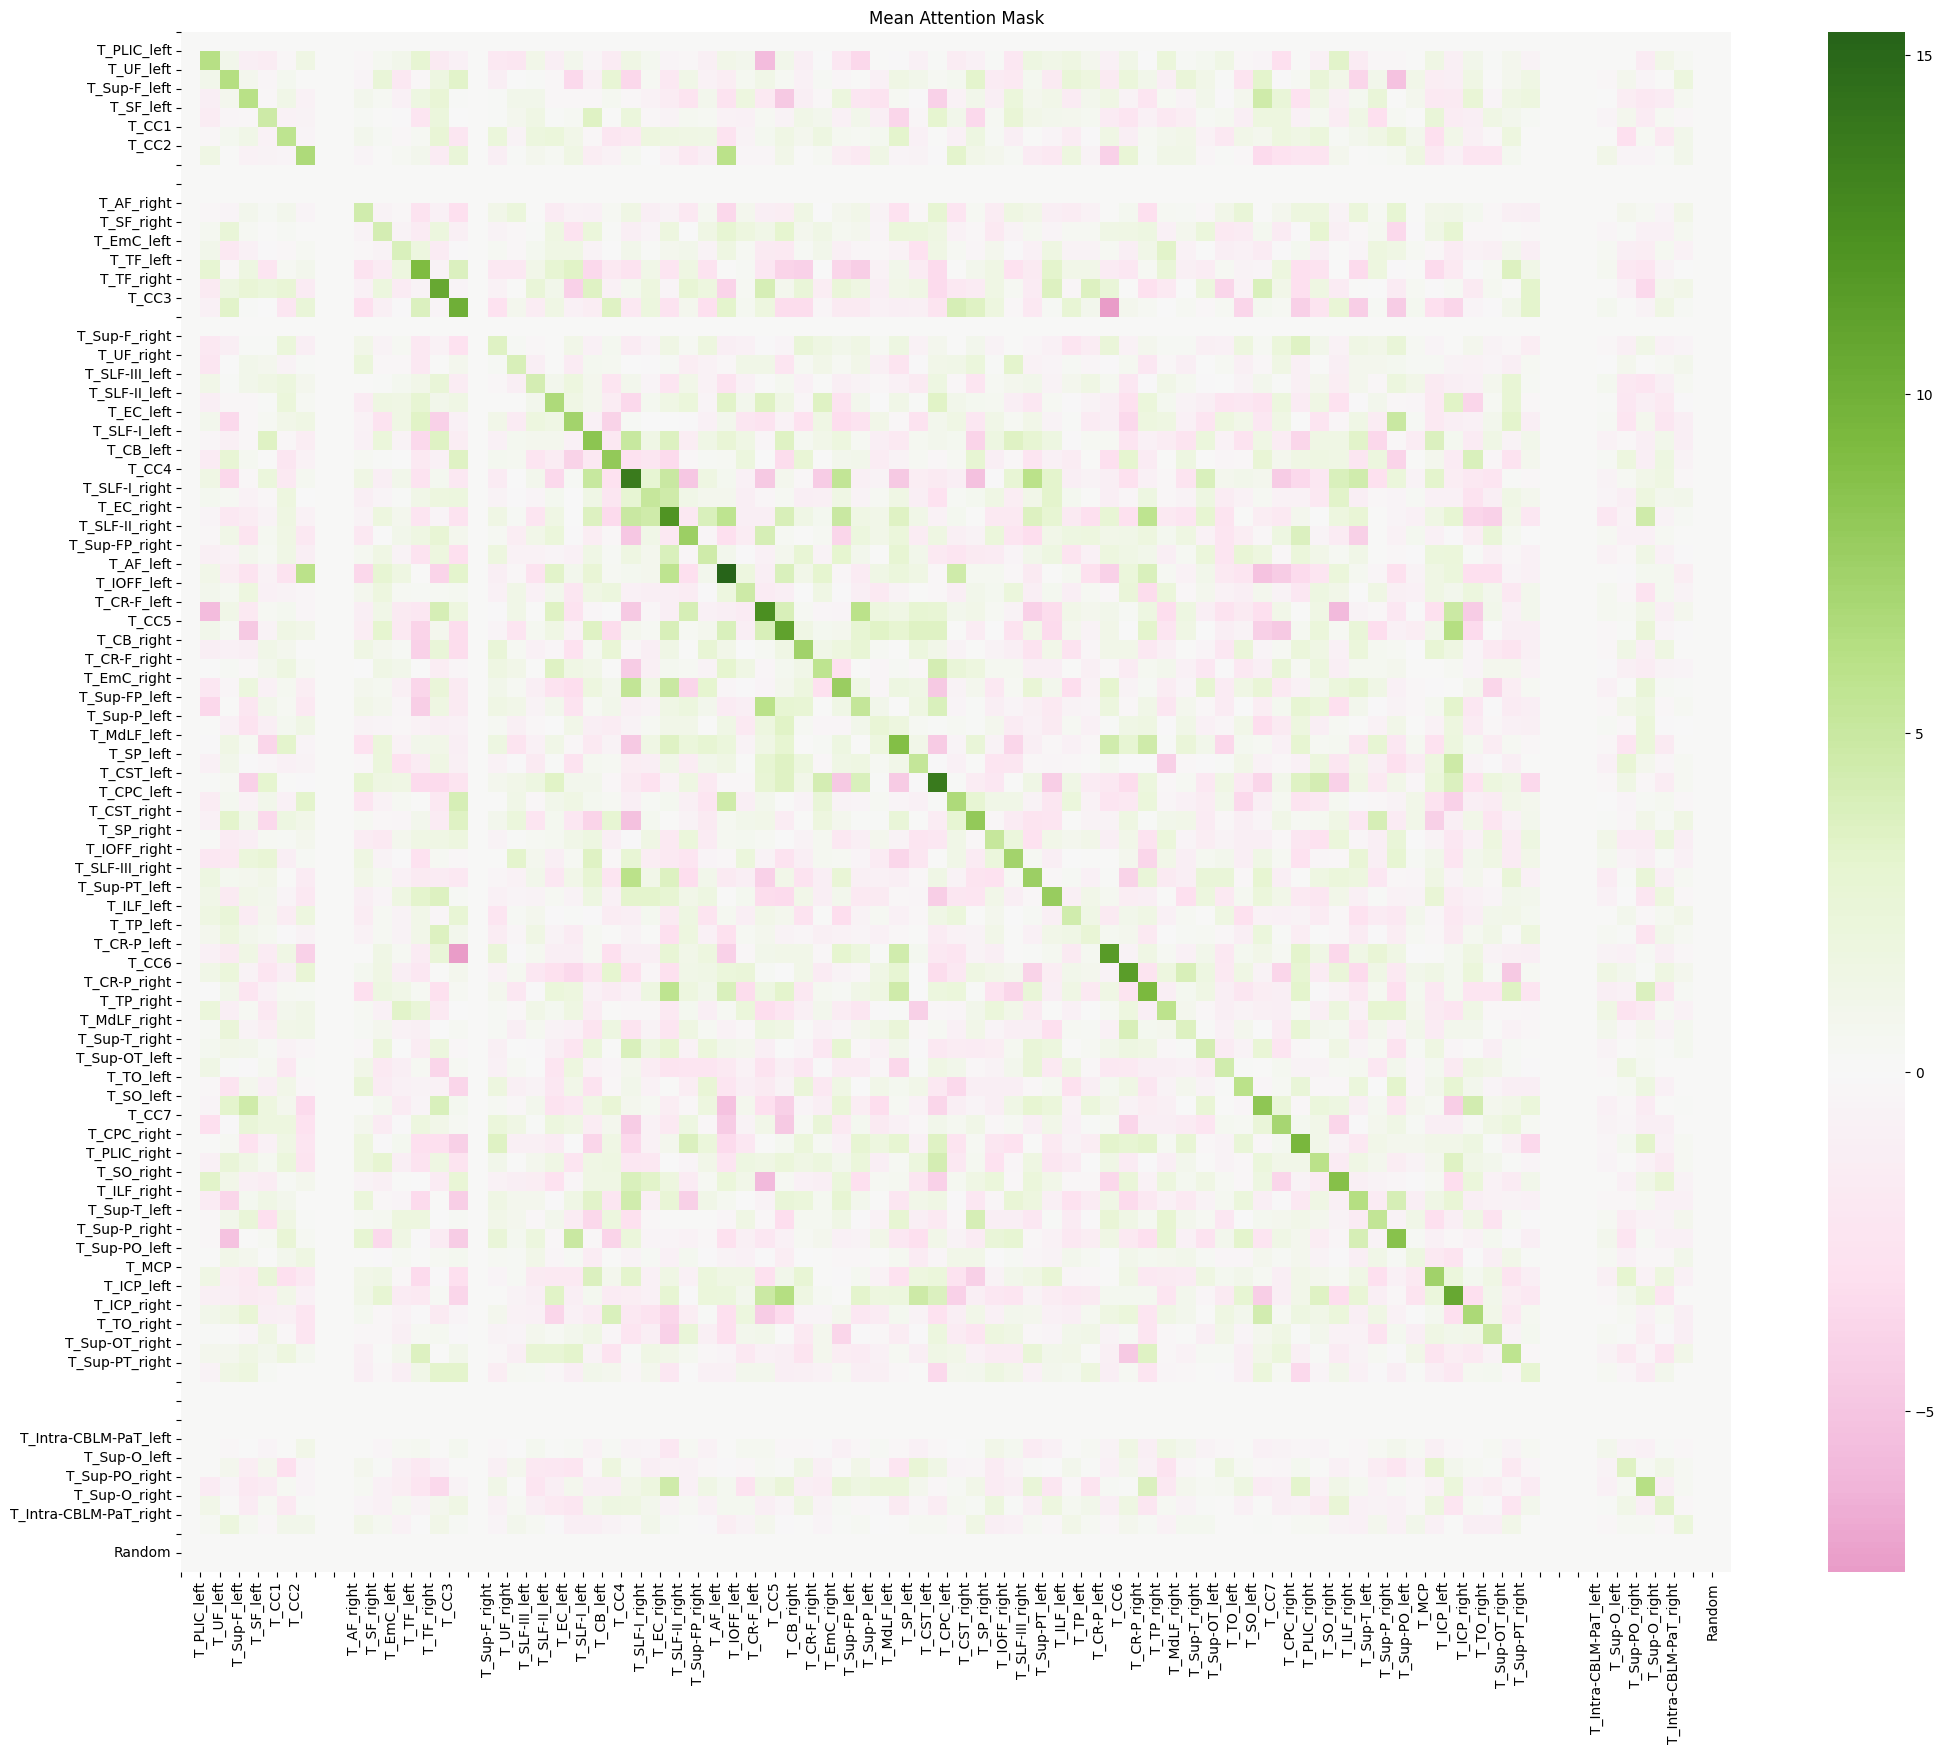

In [109]:
## Plot the interaction matrix
interaction_matrix = model.get_interactions(torch.tensor(X_test, dtype=torch.float32).to(device))
interaction_matrix = interaction_matrix.cpu().detach().numpy()
interaction_matrix = interaction_matrix.mean(axis=0)
## Make the diagonal of the interaction matrix 0
# np.fill_diagonal(interaction_matrix, 0)
tract_names = dti_representation.reshape(-1)

reshaped_attn_mask = np.array([interaction_matrix]).reshape(-1, 81,81)
## Min Max scale the attention mask
# reshaped_attn_mask = (reshaped_attn_mask - np.min(reshaped_attn_mask)) / (np.max(reshaped_attn_mask) - np.min(reshaped_attn_mask))
mean_attn_mask = np.mean(reshaped_attn_mask, axis=0)
## Plot the attention mask
plt.figure(figsize=(25, 20))
sns.heatmap(mean_attn_mask, cmap='PiYG', center=0)
## Put tract names as axis
plt.xticks(np.arange(81), tract_names, rotation=90)
plt.yticks(np.arange(81), tract_names, rotation=0)
plt.title('Mean Attention Mask')
plt.show()


## Checking the Latent Space

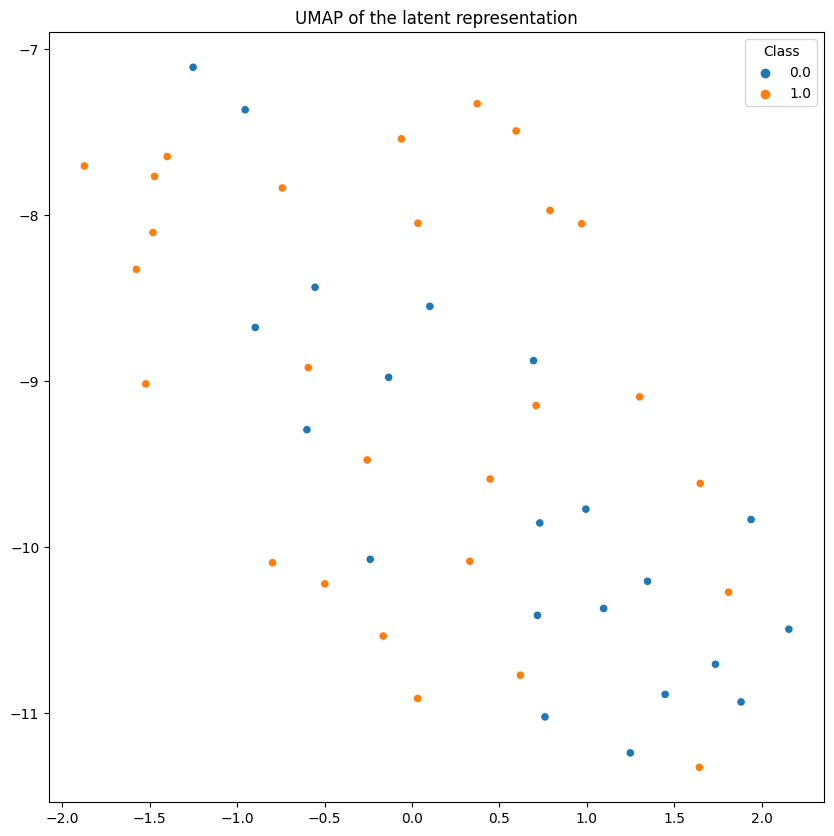

0.7916666666666666

In [115]:
## Get a latent encoding of the test data
_, _, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32).to(device))
## Get reparepresentation of the test data
mu = mu.cpu().detach().numpy()
fm_feats = fm_feats.cpu().detach().numpy()
mu = np.concatenate([mu, fm_feats], axis=1)

## Plot z with UMAP clustering
reducer = umap.UMAP()
z_umap = reducer.fit_transform(mu)
## Scatter Plot with Legend
plt.figure(figsize=(10, 10))
sns.scatterplot(x=z_umap[:, 0], y=z_umap[:, 1], hue=Y_test.cpu().detach().numpy())
plt.legend(title='Class')
plt.title('UMAP of the latent representation')
plt.show()

## Get teh KNN accuracy of the latent representation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(mu, Y_test.cpu().detach().numpy())
y_pred = knn.predict(mu)
accuracy_score(Y_test.cpu().detach().numpy(), y_pred)


### XAI test on the latent vector

In [111]:
from sklearn.decomposition import PCA

In [112]:
## Encode the entire X_test
model.eval()
with torch.no_grad():
    x_recon, y_pred, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get the encoder's z
    z = model.reparameterize(mu, logvar)
    

In [116]:
## Making explanability class
class Exp_Model:
    def __init__(self, model, tract):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)
        self.tract = tract
        self.dti_representation = np.load('../Dataset/NEUROFIT_diffusion/aggregated_grid.npy', allow_pickle=True)

    def predict(self, embedding):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        ## Change embedding to tensor if not tensor
        if not torch.is_tensor(embedding):
            embedding = torch.tensor(embedding, dtype=torch.float32).to(self.device)
        
        ## Change embedding to 2x2x8
        embedding = embedding.view(embedding.size(0), 4, 2, 2)
        output = model.decode(embedding)
        
        ## In dti representation, find the index of the tract name
        tract_index = [i[0] for i in np.where(self.dti_representation==self.tract)]
        tract_output =  output[:,0,tract_index[0], tract_index[1]]

        ## Convert to numpy and return
        return tract_output.cpu().detach().numpy()
        

  0%|          | 0/73 [00:00<?, ?it/s]

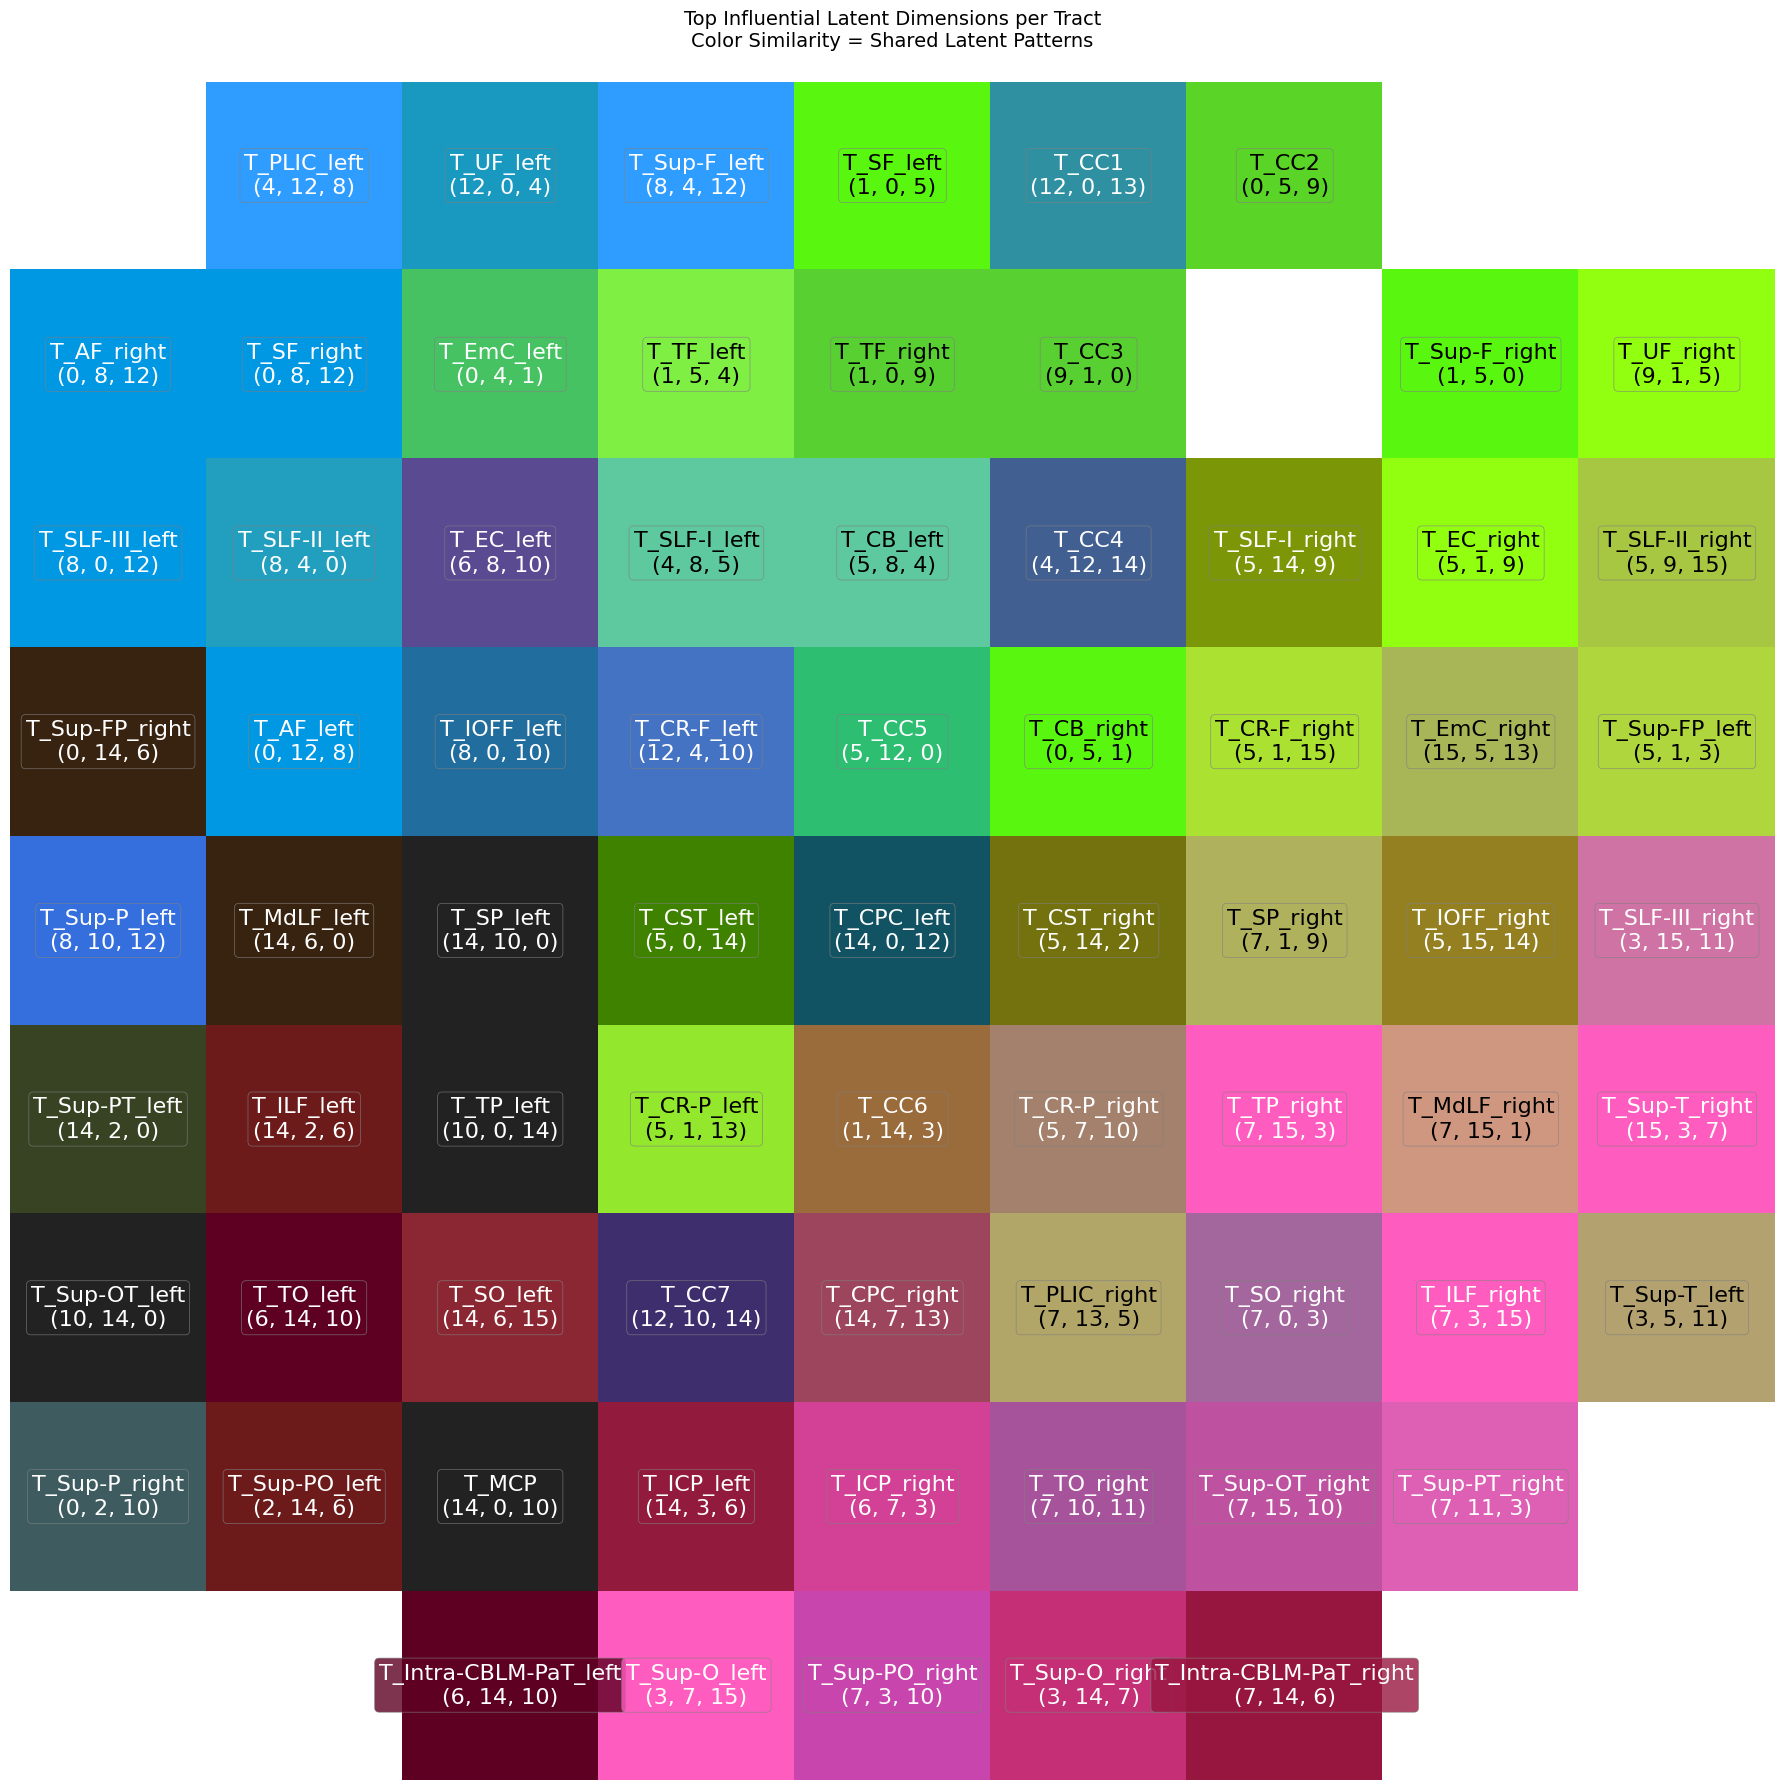

In [117]:
# ... [Keep all previous imports and device setup] ...

# =============================================
# Improved SHAP Explanation with Color Coding
# =============================================

def compute_tract_similarity(top_vectors):
    """Compute Jaccard similarity between tract vectors"""
    tracts = list(top_vectors.keys())
    similarity = np.zeros((len(tracts), len(tracts)))
    
    for i, t1 in enumerate(tracts):
        for j, t2 in enumerate(tracts):
            set1 = set(top_vectors[t1])
            set2 = set(top_vectors[t2])
            similarity[i,j] = len(set1 & set2)/len(set1 | set2)
            
    return similarity, tracts

# Create common background for all explainers
background = z[np.random.choice(len(z), 100, replace=True)].cpu().detach().numpy()

top_vectors = {}
tract_list = list(set(dti_representation.reshape(-1)) - {''})

# First pass: Compute all SHAP values
for tract in tqdm(tract_list):
    if tract != 'Random':
        explanability_model = Exp_Model(model, tract)
        
        # Create explainer with proper background
        explainer = shap.Explainer(
            explanability_model.predict, 
            background, 
            algorithm='auto'
        )
        
        # Compute SHAP values
        shap_values = explainer(z.cpu().detach().numpy())
        
        # Store top 3 vectors (using absolute values for magnitude)
        mean_vals = np.abs(shap_values.values).mean(axis=0)
        top_vectors[tract] = mean_vals.argsort()[-3:][::-1]

        # ## Save shap summary plot C:\Users\vishw\OneDrive\Desktop\Projects\cBRAIN_modality_testing\Dataset\Autoencoder_SHAP_Plots with {tract}.png
        # plt.figure(figsize=(10, 10))
        # shap.summary_plot(shap_values, z.cpu().detach().numpy(), feature_names=[i for i in range(z.shape[1])], show=False)
        # plt.savefig(f'../Dataset/Autoencoder_SHAP_Plots/{tract}.png')
        # plt.close()

# =============================================
# Enhanced Visualization with Color Coding
# =============================================

# Compute similarity matrix
similarity, tracts = compute_tract_similarity(top_vectors)

# Reduce to 3D color space using PCA
pca = PCA(n_components=3)
colors = pca.fit_transform(similarity)
colors = (colors - colors.min(0)) / (colors.max(0) - colors.min(0))  # Normalize 0-1

# Create color map and text matrix
tract_to_color = {tract: colors[i] for i, tract in enumerate(tracts)}
cell_text = np.empty_like(dti_representation, dtype=object)
cell_colors = np.ones((*dti_representation.shape, 3))  # White background

for i in range(dti_representation.shape[0]):
    for j in range(dti_representation.shape[1]):
        tract = dti_representation[i,j]
        if tract != '' and tract != 'Random':
            # Format text with top vectors
            vectors = ', '.join(map(str, top_vectors[tract]))
            cell_text[i,j] = f"{tract}\n({vectors})"
            
            # Assign color from PCA projection
            cell_colors[i,j] = tract_to_color[tract]

# Create plot with improved styling
plt.figure(figsize=(18, 18))
ax = plt.gca()

# Create colored background
ax.imshow(cell_colors, interpolation='nearest', aspect='auto')

# Add text with automatic color contrast
for (i,j), val in np.ndenumerate(cell_text):
    if val is not None:
        # Calculate background brightness
        bg_brightness = 0.299 * cell_colors[i,j,0] + 0.587 * cell_colors[i,j,1] + 0.114 * cell_colors[i,j,2]
        text_color = 'black' if bg_brightness > 0.6 else 'white'
        
        ax.text(j, i, val, 
               ha='center', va='center', 
               fontsize=16, 
               color=text_color,
               bbox=dict(
                   boxstyle='round,pad=0.2',
                   facecolor=cell_colors[i,j],
                   edgecolor='grey',
                   linewidth=0.5,
                   alpha=0.8
               ))

# Grid formatting
ax.set_xticks(np.arange(-.5, dti_representation.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, dti_representation.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
ax.tick_params(which='both', length=0)
## Remove axis
plt.axis('off')

plt.title("Top Influential Latent Dimensions per Tract\nColor Similarity = Shared Latent Patterns", pad=25, fontsize=14)
plt.tight_layout()
plt.show()

## MIG Calculation

In [83]:
from sklearn.metrics import mutual_info_score

In [84]:
# test_grids = [
#     # Sample 1: Only left hemisphere tracts
#     np.array([
#         ['', 'T_PLIC_left', 'T_UF_left', 'T_Sup-F_left', 'T_SF_left',
#          '', '', '', ''],
#         ['', '', 'T_EmC_left', 'T_TF_left', '', '', '', '', ''],
#         ['T_SLF-III_left', 'T_SLF-II_left', 'T_EC_left', 'T_SLF-I_left',
#          'T_CB_left', '', '', '', ''],
#         ['', 'T_AF_left', 'T_IOFF_left', 'T_CR-F_left', '', '', '', '', ''],
#         ['T_Sup-P_left', 'T_MdLF_left', 'T_SP_left', 'T_CST_left', '', 
#          '', '', '', ''],
#         ['T_Sup-PT_left', 'T_ILF_left', 'T_TP_left', 'T_CR-P_left', '', 
#          '', '', '', ''],
#         ['T_Sup-OT_left', 'T_TO_left', 'T_SO_left', '', '', '', '', '', ''],
#         ['', '', '', '', '', '', '', '', ''],
#         ['', '', 'T_Intra-CBLM-PaT_left', '', '', '', '', '', '']
#     ], dtype=object),

#     # # Sample 2: Only right hemisphere tracts
#     np.array([
#         ['', '', '', '', '', '', '', '', ''],
#         ['T_AF_right', 'T_SF_right', '', '', 'T_TF_right', '', '', 'T_Sup-F_right', 'T_UF_right'],
#         ['', '', '', '', '', '', 'T_SLF-I_right', 'T_EC_right', 'T_SLF-II_right'],
#         ['T_Sup-FP_right', '', '', '', '', 'T_CB_right', 'T_CR-F_right', 'T_EmC_right', ''],
#         ['', '', '', '', '', 'T_CST_right', 'T_SP_right', 'T_IOFF_right', 'T_SLF-III_right'],
#         ['', '', '', '', '', 'T_CR-P_right', 'T_TP_right', 'T_MdLF_right', 'T_Sup-T_right'],
#         ['', '', '', '', 'T_CPC_right', 'T_PLIC_right', 'T_SO_right', 'T_ILF_right', ''],
#         ['T_Sup-P_right', '', '', '', '', '', 'T_Sup-OT_right', '', ''],
#         ['', '', '', '', 'T_Sup-PO_right', 'T_Sup-O_right', '', '', '']
#     ], dtype=object),

#     # # Sample 3: Mixed tracts + corpus callosum
#     np.array([
#         ['', '', '', '', 'T_SF_left', 'T_CC1', 'T_CC2', '', ''],
#         ['', 'T_SF_right', '', '', '', 'T_CC3', '', '', ''],
#         ['', '', '', '', '', 'T_CC4', '', '', ''],
#         ['', '', '', '', 'T_CC5', '', '', '', ''],
#         ['', '', '', '', 'T_CPC_left', '', '', '', ''],
#         ['', '', '', '', 'T_CC6', '', '', '', ''],
#         ['', '', '', 'T_CC7', '', '', '', '', ''],
#         ['', '', 'T_MCP', '', '', '', '', '', ''],
#         ['', '', '', '', '', '', '', '', '']
#     ], dtype=object),]

frontal_grid = np.array([
    ['', 'T_Sup-F_left', 'T_SF_left', 'T_AF_left', 'T_TF_left', '', '', '', ''],
    ['', 'T_SF_right', 'T_Sup-F_right', 'T_AF_right', 'T_TF_right', 'T_Sup-FP_right', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Temporal region factor
temporal_grid = np.array([
    ['', 'T_UF_left', 'T_ILF_left', 'T_TP_left', 'T_TO_left', 'T_SO_left', 'T_EC_left', '', ''],
    ['', 'T_UF_right', 'T_ILF_right', 'T_TP_right', 'T_SO_right', 'T_EC_right', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Parietal region factor
parietal_grid = np.array([
    ['T_SLF-III_left', 'T_SLF-II_left', 'T_SLF-I_left', 'T_SP_left', 'T_MdLF_left', '', '', '', ''],
    ['T_SLF-III_right', 'T_SLF-II_right', 'T_SLF-I_right', 'T_SP_right', 'T_MdLF_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Occipital region factor
occipital_grid = np.array([
    ['', 'T_IOFF_left', 'T_Sup-OT_left', '', '', '', '', '', ''],
    ['', 'T_IOFF_right', 'T_Sup-OT_right', 'T_Sup-O_right', 'T_Sup-PO_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Projection/Subcortical region factor
projection_grid = np.array([
    ['T_PLIC_left', 'T_CST_left', 'T_CB_left', 'T_CR-F_left', 'T_CR-P_left', '', '', '', ''],
    ['T_PLIC_right', 'T_CST_right', 'T_CB_right', 'T_CR-F_right', 'T_CR-P_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Cerebellar region factor
cerebellar_grid = np.array([
    ['T_Intra-CBLM-PaT_left', '', '', '', '', '', '', '', ''],
    ['T_CPC_left', 'T_CPC_right', 'T_MCP', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Corpus Callosum factor (if desired)
cc_grid = np.array([
    ['', '', 'T_CC1', 'T_CC2', '', '', '', '', ''],
    ['', 'T_CC3', '', '', '', '', '', '', ''],
    ['', '', 'T_CC4', '', '', '', '', '', ''],
    ['', '', 'T_CC5', '', '', '', '', '', ''],
    ['', '', 'T_CC6', '', '', '', '', '', ''],
    ['', '', 'T_CC7', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Combine all region factors into a list (or dict for labeled access)
test_grids = [frontal_grid,
               temporal_grid, 
               parietal_grid, 
               occipital_grid, 
               projection_grid, 
               cerebellar_grid]

In [85]:
# Create mapping between tracts and their grid positions
tract_positions = {}
for i in range(9):
    for j in range(9):
        tract = dti_representation[i, j]
        if tract.strip():
            tract_positions[tract] = (i, j)

tract_list = list(tract_positions.keys())

def create_factor_matrix(sample_grids):
    """Convert list of 9x9 grids to binary factor matrix"""
    n_samples = len(sample_grids)
    factor_matrix = np.zeros((n_samples, len(tract_list)), dtype=int)
    
    for idx, grid in enumerate(sample_grids):
        for tract_idx, tract in enumerate(tract_list):
            i, j = tract_positions[tract]
            factor_matrix[idx, tract_idx] = int(grid[i, j].strip() != '')
            
    return factor_matrix


def compute_tract_mig(model, X_test, tract_factors):
    """Compute MIG specifically for tract presence factors"""
    model.eval()
    device = next(model.parameters()).device
    
    # Get latent representations
    with torch.no_grad():
        X_test = X_test.float().to(device)
        mu, _ = model.encode(X_test)
    latents = mu.cpu().numpy()
    
    # Compute Mutual Information Gap
    n_factors = tract_factors.shape[1]
    latent_dim = latents.shape[1]
    mig_scores = []
    
    for tract_idx in range(n_factors):
        factor = tract_factors[:, tract_idx]
        mi_scores = []
        
        for latent_dim in range(latent_dim):
            mi = mutual_info_score(factor, latents[:, latent_dim])
            mi_scores.append(mi)
            
        sorted_mi = np.sort(mi_scores)[::-1]
        mig = (sorted_mi[0] - sorted_mi[1]) / np.log(2)  # Binary factors
        mig_scores.append(mig)
    
    return {
        'mean_mig': np.mean(mig_scores),
        'tract_migs': mig_scores,
        'tract_names': tract_list
    }

ground_truth_factors = create_factor_matrix(test_grids)


In [86]:
import numpy as np

# Generate 48 synthetic samples that match your real X_test size
n_samples = 48  # Should match len(X_test)
test_grids = []

for _ in range(n_samples):
    # Create a blank 9x9 grid
    grid = np.full((9, 9), '', dtype=object)
    
    # Randomly activate 5-15 tracts per sample
    n_tracts = np.random.randint(5, 15)
    for _ in range(n_tracts):
        i, j = np.random.randint(0, 9, 2)
        tract = dti_representation[i, j]
        if tract.strip():  # Only populate valid tract positions
            grid[i, j] = tract
    
    test_grids.append(grid)

# Verify shape
def create_factor_matrix(sample_grids):
    """Convert list of 9x9 grids to binary factor matrix"""
    tract_positions = {}
    for i in range(9):
        for j in range(9):
            tract = dti_representation[i, j]
            if tract.strip():
                tract_positions[tract] = (i, j)
    
    tract_list = list(tract_positions.keys())
    factor_matrix = np.zeros((len(sample_grids), len(tract_list)), dtype=int)
    
    for idx, grid in enumerate(sample_grids):
        for tract_idx, tract in enumerate(tract_list):
            i, j = tract_positions[tract]
            factor_matrix[idx, tract_idx] = int(grid[i, j].strip() != '')
            
    return factor_matrix

ground_truth_factors = create_factor_matrix(test_grids)
print("Factor matrix shape:", ground_truth_factors.shape)  # Should be (48, N_tracts)

Factor matrix shape: (48, 73)


In [87]:
import numpy as np
from sklearn.metrics import mutual_info_score

def compute_individual_tract_mig(model, X_test, tract_factors, tract_names, n_bins=20):
    """
    Compute MIG for each tract individually and identify best latent dimension
    
    Args:
        model: Trained VAE model
        X_test: Input images (shape [N, 9, 9])
        tract_factors: Binary matrix of tract presence (shape [N, num_tracts])
        tract_names: List of tract names corresponding to tract_factors columns
        n_bins: Number of bins for discretizing latent dimensions
        
    Returns:
        Dictionary with MIG scores and latent associations for each tract
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get latent representations
    with torch.no_grad():
        X_test = X_test.float().to(device)  # Add channel dimension
        mu, _ = model.encode(X_test)
    latents = mu.cpu().numpy()

    if len(latents.shape) == 4:
        latents = latents.reshape(-1, latents.shape[1] * latents.shape[2] * latents.shape[3])
    
    # Discretize latent dimensions
    latents_discrete = np.zeros_like(latents)
    for i in range(latents.shape[1]):
        latents_discrete[:, i] = np.digitize(latents[:, i], 
                                           np.linspace(latents[:, i].min(), 
                                                       latents[:, i].max(), 
                                                       n_bins))
    
    # Calculate entropy for each tract
    tract_entropy = []
    for k in range(tract_factors.shape[1]):
        p = np.mean(tract_factors[:, k])
        if p == 0 or p == 1:
            tract_entropy.append(0)
        else:
            tract_entropy.append(-p * np.log(p) - (1-p) * np.log(1-p))
    
    results = {}
    
    # Calculate MIG for each tract
    for tract_idx in range(tract_factors.shape[1]):
        tract = tract_names[tract_idx]
        factor = tract_factors[:, tract_idx]
        H = tract_entropy[tract_idx]
        
        if H == 0:
            # Skip tracts that are always present or absent
            results[tract] = {
                'mig': 0,
                'best_latent': None,
                'top_mi_scores': [],
                'entropy': 0
            }
            continue
            
        mi_scores = []
        for dim in range(latents_discrete.shape[1]):
            mi = mutual_info_score(factor, latents_discrete[:, dim])
            mi_scores.append((mi, dim))
            
        # Sort MI scores descending
        mi_scores.sort(reverse=True, key=lambda x: x[0])
        
        if len(mi_scores) < 2:
            mig = 0
        else:
            mig = (mi_scores[0][0] - mi_scores[1][0]) / H
            
        results[tract] = {
            'mig': mig,
            'best_latent': mi_scores[0][1],
            'top_mi_scores': mi_scores[:5],  # Top 5 latent dimensions
            'entropy': H
        }
    
    return results

# Usage example
tract_names = [t for row in dti_representation for t in row if t.strip()]  # Your tract names
results = compute_individual_tract_mig(model, X_test, ground_truth_factors, tract_names)

# Print results sorted by MIG
sorted_results = sorted(results.items(), key=lambda x: -x[1]['mig'])

print("Mean MIG Score:", np.mean([info['mig'] for info in results.values()]))
print("Tract-wise MIG Scores:")
for tract, info in sorted_results:
    if info['entropy'] == 0:
        continue  # Skip constant tracts
    print(f"{tract}:")
    print(f"  MIG: {info['mig']:.3f}")
    print(f"  Best latent: {info['best_latent']}")
    print(f"  Top MI scores: {[f'Latent {dim}: {score:.3f}' for score, dim in info['top_mi_scores']]} ")
    print("-------------------")

Mean MIG Score: 0.06903792299311064
Tract-wise MIG Scores:
T_CST_left:
  MIG: 0.285
  Best latent: 3
  Top MI scores: ['Latent 3: 0.101', 'Latent 20: 0.072', 'Latent 25: 0.072', 'Latent 0: 0.061', 'Latent 27: 0.061'] 
-------------------
T_ICP_right:
  MIG: 0.285
  Best latent: 31
  Top MI scores: ['Latent 31: 0.101', 'Latent 9: 0.072', 'Latent 22: 0.072', 'Latent 26: 0.072', 'Latent 5: 0.072'] 
-------------------
T_UF_right:
  MIG: 0.221
  Best latent: 21
  Top MI scores: ['Latent 21: 0.321', 'Latent 31: 0.221', 'Latent 24: 0.218', 'Latent 17: 0.214', 'Latent 8: 0.212'] 
-------------------
T_SP_left:
  MIG: 0.205
  Best latent: 9
  Top MI scores: ['Latent 9: 0.276', 'Latent 0: 0.208', 'Latent 11: 0.195', 'Latent 31: 0.179', 'Latent 14: 0.177'] 
-------------------
T_EmC_right:
  MIG: 0.170
  Best latent: 5
  Top MI scores: ['Latent 5: 0.234', 'Latent 27: 0.194', 'Latent 18: 0.187', 'Latent 1: 0.182', 'Latent 13: 0.165'] 
-------------------
T_MdLF_left:
  MIG: 0.167
  Best latent: 9

## XAI Classifier

In [13]:
class Exp_Model:
    def __init__(self, model):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)

    def predict(self, x):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        x = x.view(-1,1,9,9)
        x_recon, y_pred, mu, logvar = self.model(x)
        return torch.sigmoid(y_pred).detach().cpu().numpy()


In [16]:
class Exp_Model2:
    def __init__(self, model, classifier):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)
        self.classifier = classifier

    def predict(self, x):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        x = x.view(-1,1,9,9)
        x_recon, y_pred, mu, logvar, fm_feats = self.model(x)
        mu = mu.cpu().detach().numpy()
        fm_feats = fm_feats.cpu().detach().numpy()

        ## concatenate
        mu = np.concatenate([fm_feats, mu], axis=1)
        
        pred = self.classifier.predict(mu)
        return y_pred

In [18]:
## Repeated KFold test
from sklearn.model_selection import RepeatedKFold
from lazypredict.supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
shap_results = []
device = torch.device('cuda')
for train_index, test_index in tqdm(rkf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    backbone = Spatial_DTI_autoencoder(num_classes=1, latent_dim=8, fm_latent_dim=16)
    optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()
    model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=1000,
                    batch_size=16,
                    verbose=False)
    
    ## Extract the latent vectors for X_test 
    _, _, mu, logvar, fm_feats = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get reparepresentation of the test data
    mu_test = mu.cpu().detach().numpy()
    fm_feats_test = fm_feats.cpu().detach().numpy()

    ## Get the latent vectors for X_train
    _, _, mu, logvar, fm_feats = model(torch.tensor(X_train, dtype=torch.float32).to(device))
    ## Get reparepresentation of the train data
    mu_train = mu.cpu().detach().numpy()
    fm_feats_train = fm_feats.cpu().detach().numpy()

    ## Concatenate the fm_feats and mu
    fm_feats_train = np.concatenate([fm_feats_train, mu_train], axis=1)
    fm_feats_test = np.concatenate([fm_feats_test, mu_test], axis=1)

    dtm = RandomForestClassifier()
    dtm.fit(fm_feats_train, Y_train)

    print("Mean Accuracy: ", accuracy_score(Y_test, dtm.predict(fm_feats_test)))
    print("Mean F1: ", f1_score(Y_test, dtm.predict(fm_feats_test)))
        
    
    exp_model = Exp_Model2(model, dtm)
    explainer = shap.Explainer(exp_model.predict, test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))
    shap_values = explainer(test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))

    # explainer = shap.Explainer(dtm.predict, mu_test)
    # shap_values = explainer(mu_test)

    shap_results.append(shap_values)




0it [00:00, ?it/s]

Early stopping
Best Test loss: 0.9345388412475586
Mean Accuracy:  0.6363636363636364
Mean F1:  0.75
Early stopping
Best Test loss: 0.9379396438598633
Mean Accuracy:  0.36363636363636365
Mean F1:  0.36363636363636365
Early stopping
Best Test loss: 1.0058789253234863
Mean Accuracy:  0.7272727272727273
Mean F1:  0.7692307692307693
Early stopping
Best Test loss: 0.9751574397087097
Mean Accuracy:  0.7272727272727273
Mean F1:  0.8
Early stopping
Best Test loss: 0.8239555358886719
Mean Accuracy:  0.9090909090909091
Mean F1:  0.9333333333333333
Early stopping
Best Test loss: 0.9074838757514954
Mean Accuracy:  0.5
Mean F1:  0.6153846153846154
Early stopping
Best Test loss: 0.9925496578216553
Mean Accuracy:  0.5
Mean F1:  0.4444444444444444
Early stopping
Best Test loss: 0.8918746709823608
Mean Accuracy:  0.7
Mean F1:  0.7692307692307693
Early stopping
Best Test loss: 1.0397863388061523
Mean Accuracy:  0.6
Mean F1:  0.6
Early stopping
Best Test loss: 1.0560128688812256
Mean Accuracy:  0.6
Mean F

In [19]:
merged_values = np.concatenate([ex.values for ex in shap_results], axis=0)
merged_base_values = np.concatenate([ex.base_values for ex in shap_results], axis=0)
merged_data = np.concatenate([ex.data for ex in shap_results], axis=0)

# Create a new Explanation object.
merged_explanation = shap.Explanation(
    values=merged_values,
    base_values=merged_base_values,
    data=merged_data,
    feature_names=shap_results[0].feature_names
)

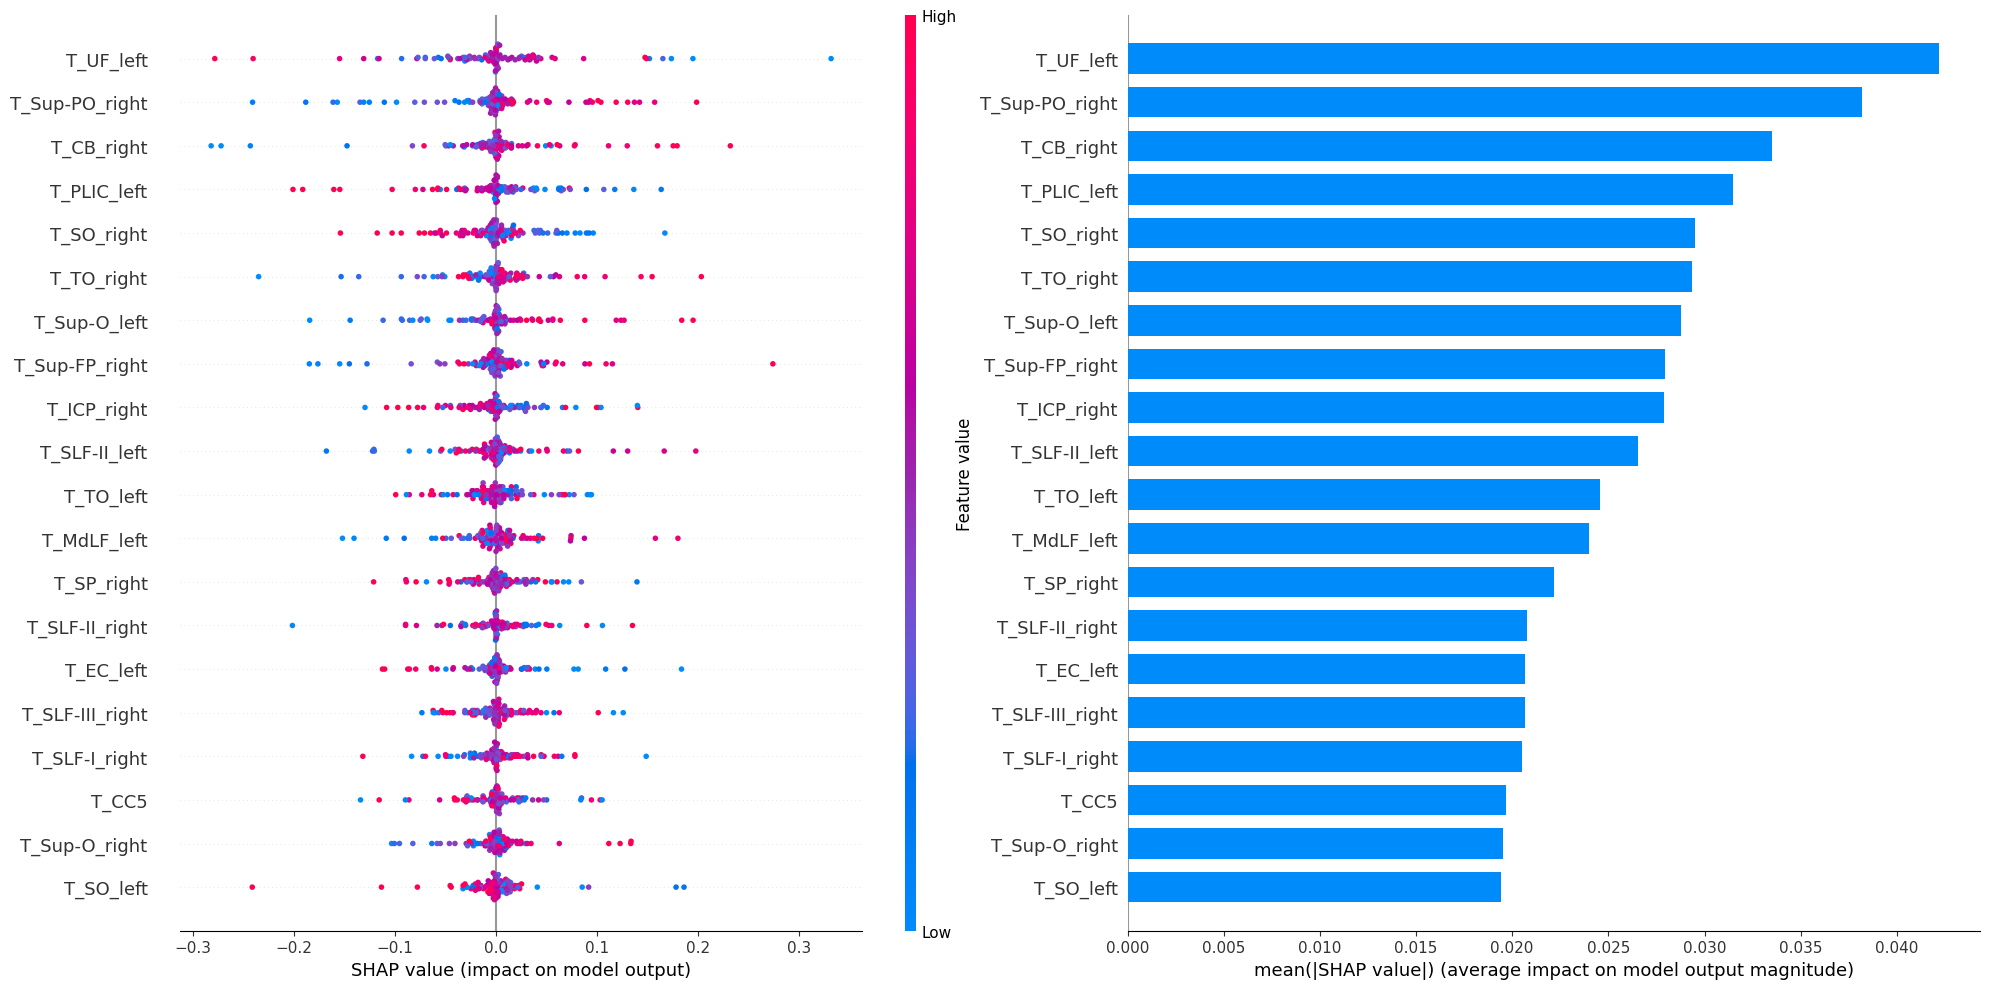

In [20]:
tract_names = dti_representation.reshape(-1)

## Make subplots for shap
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
shap.summary_plot(merged_explanation, feature_names=tract_names,show=False, plot_size=[20, 10])
plt.subplot(1, 2, 2)
shap.summary_plot(merged_explanation, feature_names=tract_names, plot_type='bar', show=False, plot_size=[20, 10])
plt.show()

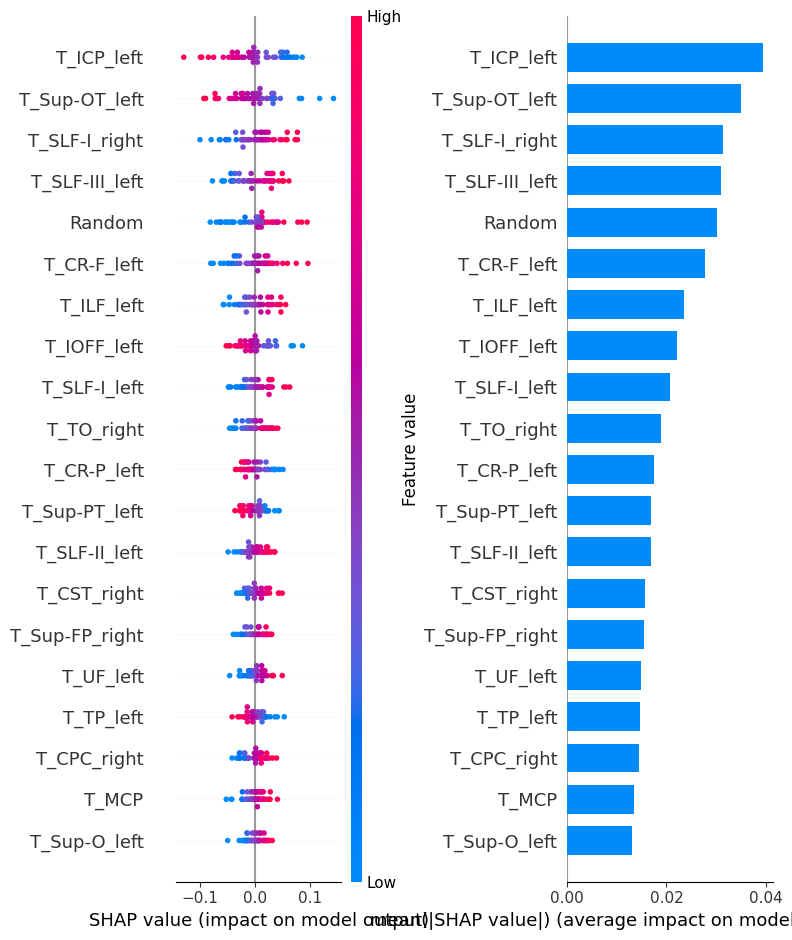

In [62]:
## Computing SHAP values
exp_model = Exp_Model(model)
explainer = shap.Explainer(exp_model.predict, test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))
shap_values = explainer(test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))
tract_names = dti_representation.reshape(-1)

## Make subplots for shap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81), feature_names=tract_names,show=False)
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81), feature_names=tract_names, plot_type='bar', show=False)
plt.show()